In [61]:
import csv
import shapely
from shapely.geometry import Point, Polygon
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import descartes
import numpy as np

#Load in the CSV Bike Station Location Data
df = pd.read_csv('../Data/HRSQ12020.csv')

#combine the latitude and longitude to make coordinates
df['coordinates'] = df[['Longitude', 'Latitude']].values.tolist()

# Change the coordinates to a geoPoint
df['coordinates'] = df['coordinates'].apply(Point)
df.head()

,Station #,Station Name,NumRacks,Latitude,Longitude,coordinates
0,1000,Liberty Ave & Stanwix St,16,40.441326,-80.004679,POINT (-80.004679 40.441326)
1,1001,Forbes Ave & Market Square,19,40.440877,-80.003080,POINT (-80.00308 40.440877)
2,1002,Third Ave & Wood St,15,40.439030,-80.001860,POINT (-80.00185999999999 40.43903)
3,1003,First Ave & Smithfield St (Art Institute),15,40.437200,-80.000375,POINT (-80.00037500000001 40.4372)
4,1004,First Ave & B St (T Station),15,40.435887,-79.997102,POINT (-79.997102 40.435887)


In [62]:
#fixing wrong negative value for Latitude
df.loc[df["Latitude"] == df["Latitude"].min()]
df.at[80, 'Latitude'] = 40.467715

df.to_csv('../Data/bikes_station_location.csv', index=False)  

#count the number of racks at each station
rackTot = 0
for index, row in df.iterrows():
      rackTot += row['NumRacks']
print(rackTot)

1085


In [63]:
geometry = [Point(xy) for xy in zip(df.Longitude, df.Latitude)]
geobikes = gpd.GeoDataFrame(df, crs='EPSG:2956', geometry=geometry)
geobikes.head()

,Station #,Station Name,NumRacks,Latitude,Longitude,coordinates,geometry
0,1000,Liberty Ave & Stanwix St,16,40.441326,-80.004679,POINT (-80.004679 40.441326),POINT (-80.00468 40.44133)
1,1001,Forbes Ave & Market Square,19,40.440877,-80.003080,POINT (-80.00308 40.440877),POINT (-80.00308 40.44088)
2,1002,Third Ave & Wood St,15,40.439030,-80.001860,POINT (-80.00185999999999 40.43903),POINT (-80.00186 40.43903)
3,1003,First Ave & Smithfield St (Art Institute),15,40.437200,-80.000375,POINT (-80.00037500000001 40.4372),POINT (-80.00038 40.43720)
4,1004,First Ave & B St (T Station),15,40.435887,-79.997102,POINT (-79.997102 40.435887),POINT (-79.99710 40.43589)


<AxesSubplot:>

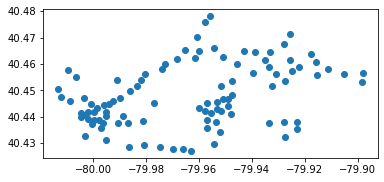

In [64]:
#plot the geodf
geobikes.plot()

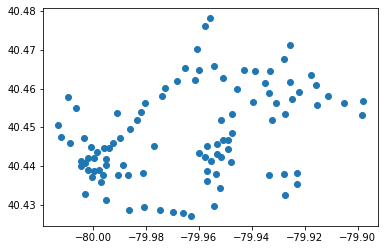

In [65]:
plt.scatter(df['Longitude'], df['Latitude'])
plt.show()

<AxesSubplot:>

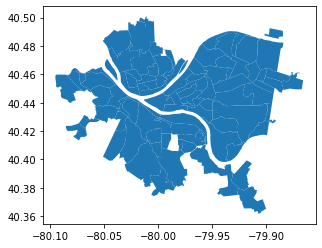

In [66]:
#Plot the Pittsburgh Neighborhoods
pittMap = gpd.read_file('../Data/Neighborhoods/ecc95d19-e9fb-46a3-be05-e7e103f362a52020328-1-565pof.jnegf.shp')
pittMap.plot()

<AxesSubplot:>

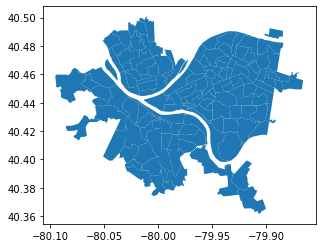

In [67]:
censusTract = gpd.read_file('../Data/2010_Census_Tracts/a36fc9b1-4e53-4fd1-80fb-db1554e213422020328-1-nbfxcj.l6b8.shp')
censusTract.plot()

In [68]:
# total area for the grid
xmin, ymin, xmax, ymax= censusTract.total_bounds

# how many cells across and down
n_cells=50
cell_size = (xmax-xmin)/n_cells
print(cell_size)
from pyproj import Proj
# projection of the grid
crs = "+proj=lcc +lat_1=40.96666666666667 +lat_2=39.93333333333333 +lat_0=39.33333333333334 +lon_0=-77.75 +x_0=600000 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs"
# crs = 4326
# create the cells in a loop
grid_cells = []
for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
    for y0 in np.arange(ymin, ymax+(cell_size), cell_size):
        # bounds
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append(shapely.geometry.box(x0, y0, x1, y1)  )
cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'], 
                                 crs=crs)
map_points = gpd.GeoDataFrame()
cell["centroid"] = cell["geometry"].centroid
map_points["geometry"] = cell["geometry"].centroid

0.004590788537153969


<AxesSubplot:>

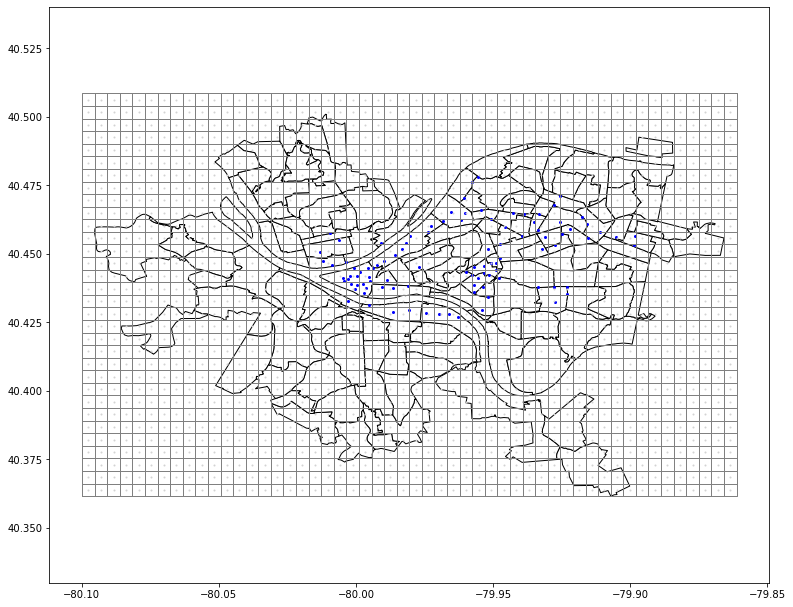

In [69]:
#Use matplotlib to plot the pittsburgh neighborhoods
fig, ax = plt.subplots(1, figsize=(10, 8))
ax.set_position([0,0,1,1])   # Puts axis to edge of figure
lims = plt.axis('equal')
ax.set_aspect('equal')
censusTract.plot(ax = ax, color='white', edgecolor='black')

geobikes.plot(ax=ax, markersize=4, color='blue')
map_points.plot(ax=ax, markersize=1, color='lightgrey')
cell.plot(ax=ax, facecolor="none", edgecolor='grey')
# ax.axis('off')

In [70]:
cell.head(1) #has four coordinate pairs

,geometry,centroid
0,"POLYGON ((-80.09993 40.36161, -80.09993 40.366...",POINT (-80.09763 40.36391)


In [71]:
cell.to_csv('../Data/PGH/cells.csv')

In [72]:
map_points.head(1) #has one coordinate pair

,geometry
0,POINT (-80.09763 40.36391)


In [73]:
from pyproj import Proj
'''declare NAD83 State plane coordinate system for South Penn'''
p1 = Proj('+proj=lcc +lat_1=40.96666666666667 +lat_2=39.93333333333333 +lat_0=39.33333333333334 +lon_0=-77.75 +x_0=600000 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs')
'''Test with sample latitude and longitude from Pittsburgh'''
sample_lat = 40.453372848142976
sample_long = -80.00290686110762
'''convert to state plane coordinates in meters'''
sp_lat, sp_long = p1(latitude=sample_lat, longitude=sample_long)
print('sp_lat = {}, sp_long = {}'.format(sp_lat, sp_long))
'''convert back to test'''
long, lat = p1(sp_lat, sp_long, inverse=True)
print('lat = {}, long = {}'.format(lat, long))

sp_lat = 408922.433628824, sp_long = 126801.0709187566
lat = 40.45337284814283, long = -80.00290686110762


In [74]:
cell['stations'] = 0 #number of stations in that cell
cell['capacity'] = 0 #total capacity of all stations in cell added together
cell['ids'] = None
len(cell)

1664

In [75]:
len(map_points)

1664

In [76]:
cell['tractce10'] = ''

In [77]:
cell.head(5)

,geometry,centroid,stations,capacity,ids,tractce10
0,"POLYGON ((-80.09993 40.36161, -80.09993 40.366...",POINT (-80.09763 40.36391),0,0,None,
1,"POLYGON ((-80.09993 40.36620, -80.09993 40.370...",POINT (-80.09763 40.36850),0,0,None,
2,"POLYGON ((-80.09993 40.37079, -80.09993 40.375...",POINT (-80.09763 40.37309),0,0,None,
3,"POLYGON ((-80.09993 40.37538, -80.09993 40.379...",POINT (-80.09763 40.37768),0,0,None,
4,"POLYGON ((-80.09993 40.37997, -80.09993 40.384...",POINT (-80.09763 40.38227),0,0,None,


In [78]:
stations_centract_df = gpd.read_file('../Data/stations_census_tracts.csv')
stations_centract_df = stations_centract_df.rename(columns={'Station #': 'station_id'})
stations_centract_df["tractce10"]= stations_centract_df["tractce10"].astype(str)
stations_centract_df["Latitude"]= stations_centract_df["Latitude"].astype(float)
stations_centract_df["Longitude"]= stations_centract_df["Longitude"].astype(float)
stations_centract_df = stations_centract_df.drop(columns=['coordinates'])

geometry = [Point(xy) for xy in zip(stations_centract_df.Longitude, stations_centract_df.Latitude)]
crs = 4326
station_gdf = gpd.GeoDataFrame(stations_centract_df, crs=crs, geometry=geometry)

for i in range(len(stations_centract_df)):
    if len(stations_centract_df.loc[i]['tractce10']) == 5:
        stations_centract_df.at[i, 'tractce10'] = '0' + stations_centract_df.loc[i]['tractce10']

In [79]:
stations_dict = dict(zip(stations_centract_df['station_id'], stations_centract_df['NumRacks']))

In [80]:
stations_dict['1000']

'16'

### If bike station in cell, increment count for number of stations in that cell

In [81]:
stations_cells = {}
found = False
for row in range(len(stations_centract_df)):
    stationid = stations_centract_df.loc[row]['station_id']
    for cellnum in range(len(cell)):
        if not found:
            if stations_centract_df.loc[row]["geometry"].within(cell.loc[cellnum]["geometry"]):
                cell.at[cellnum,'stations'] += 1
                cell.at[cellnum, 'capacity'] += int(stations_dict[str(stationid)])
                print(stationid)
                print(cellnum)
                found = True
                if cellnum not in stations_cells:
                    stations_cells[cellnum] = [stationid]
                else:
                    stations_cells[cellnum].append(stationid)
    found = False

1000
657
1001
689
1002
688
1003
688
1004
720
1005
720
1006
721
1007
784
1008
785
1009
754
1010
722
1011
690
1012
626
1013
658
1014
595
1015
660
1016
787
1017
819
1018
1017
1019
983
1020
1014
1021
1046
1022
1077
1023
1108
1024
1173
1025
1174
1026
1205
1027
1237
1028
1300
1029
1236
1031
1172
1032
1203
1033
1171
1034
1074
1035
1042
1036
1041
1037
1073
1038
1039
1039
1008
1040
1010
1041
1009
1042
850
1043
1076
1044
1008
1045
942
1046
910
1047
878
1048
814
1049
782
1052
752
1053
1333
1054
688
1056
689
1059
852
1060
885
1061
917
1062
1110
1063
1142
1064
1301
1066
1395
1068
1232
1069
1232
1070
1199
1072
687
1074
719
1084
942
1088
1006
1091
1008
1093
1009
1094
977
1095
1009
1097
1010
1099
1041
49251
1168
49261
1200
49271
1042
49301
1043
49311
1364
49321
1396
49371
1270
49391
1207
49401
1207
49441
1141
49501
982
49561
984
49581
981
49601
885
49611
820
49621
786
49641
754
49651
721
49671
721
49691
689
49701
657
49731
720
49781
816
49801
756
49881
628
49921
626
49951
950


In [82]:
cell.loc[657]

geometry     POLYGON ((-80.0081117223971 40.43965382415906,...
centroid          POINT (-80.00581632812852 40.44194921842764)
stations                                                     2
capacity                                                    21
ids                                                       None
tractce10                                                     
Name: 657, dtype: object

In [83]:
stations_cells

{657: ['1000', '49701'],
 689: ['1001', '1056', '49691'],
 688: ['1002', '1003', '1054'],
 720: ['1004', '1005', '49731'],
 721: ['1006', '49651', '49671'],
 784: ['1007'],
 785: ['1008'],
 754: ['1009', '49641'],
 722: ['1010'],
 690: ['1011'],
 626: ['1012', '49921'],
 658: ['1013'],
 595: ['1014'],
 660: ['1015'],
 787: ['1016'],
 819: ['1017'],
 1017: ['1018'],
 983: ['1019'],
 1014: ['1020'],
 1046: ['1021'],
 1077: ['1022'],
 1108: ['1023'],
 1173: ['1024'],
 1174: ['1025'],
 1205: ['1026'],
 1237: ['1027'],
 1300: ['1028'],
 1236: ['1029'],
 1172: ['1031'],
 1203: ['1032'],
 1171: ['1033'],
 1074: ['1034'],
 1042: ['1035', '49271'],
 1041: ['1036', '1099'],
 1073: ['1037'],
 1039: ['1038'],
 1008: ['1039', '1044', '1091'],
 1010: ['1040', '1097'],
 1009: ['1041', '1093', '1095'],
 850: ['1042'],
 1076: ['1043'],
 942: ['1045', '1084'],
 910: ['1046'],
 878: ['1047'],
 814: ['1048'],
 782: ['1049'],
 752: ['1052'],
 1333: ['1053'],
 852: ['1059'],
 885: ['1060', '49601'],
 917: [

In [23]:
cell.to_csv('../Data/PGH/cell_pgh.csv')

In [88]:
import json

with open('../Data/PGH/station_cells_list.json', 'w') as fp:
    json.dump(stations_cells, fp)

In [ ]:
running = 0
cellsfilled = []
for row in range(len(cell)):
    if cell.loc[row]['stations'] != 0:
#         print("row: " + str(row))
#         print("numb: " + str(cell.loc[row]['stations']))
        running += cell.loc[row]['stations']
        cellsfilled.append(row)

In [ ]:
running

In [ ]:
list1 = []
for row in range(len(stations_centract_df)):
    list1.append(stations_centract_df.loc[row]['station_id'])

## If the cell centroid is in a census tract, add the tract number to that cell

In [ ]:
for row in range(len(censusTract)):
    for cellnum in range(len(cell)):
        if cell.loc[cellnum]["centroid"].within(censusTract.loc[row]["geometry"]):
            cell.at[cellnum,'tractce10'] = censusTract.loc[row]['tractce10']

In [ ]:
cellsfilled2 = []
for row in range(len(cell)):
    if cell.loc[row]['stations'] != 0:
        cellsfilled2.append(row)

In [ ]:
cell[595:1200]

In [ ]:
cell.lo

In [ ]:
type(cell)

In [ ]:
cell.to_csv("../Data/PGH/pgh_grid.csv")

## Getting bounds for OSM Points of Interest Query

In [190]:
print(cell.loc[720]['geometry'].bounds)

(-79.99893014532279, 40.43506303562191, -79.99433935678563, 40.43965382415906)


In [ ]:
pgh_grid.plot(facecolor="none", edgecolor='grey')

In [21]:
type(cells)

NameError: name 'cells' is not defined